<a href="https://colab.research.google.com/github/JPeloquin13/NLP_Portfolio/blob/main/Sim_Cluster_Fed_NLP_TF_USE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Trial - Word Embeddings - Universal Sentence Encoder (USE)  ###

To use Universal Sentence Encoder (USE) for transfer learning and extract features. Universal Sentence Encoder (USE) The Universal Sentence Encoder encodes text into high dimensional vectors that are used here for embedding the documents. The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs.

https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

In [4]:
#!pip install fedtools
#!pip install bertopic
#!pip install networkx
#!pip install matplotlib
#!pip install altair

In [9]:
import pandas as pd
import numpy as np
import re

from FedTools import MonetaryPolicyCommittee
from FedTools import BeigeBooks
from FedTools import FederalReserveMins

# import spacy
# from spacy.lang.en.stop_words import STOP_WORDS
# import en_core_web_lg

# nlp = en_core_web_lg.load()
# from spacy import displacy
# from tqdm import tqdm
# from collections import Counter

from bertopic import BERTopic

from sklearn.feature_extraction.text import CountVectorizer

import tensorflow_hub as hub
import tensorflow as tf
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# Set parameters for download



fed_mins = FederalReserveMins(
            main_url = 'https://www.federalreserve.gov',
            calendar_url ='https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm',
            start_year = 2008,
            historical_split = 2017,
            verbose = True,
            thread_num = 10)

mins_dataset = fed_mins.find_minutes()

Constructing links between 2008 and 2023
Extracting Federal Reserve Minutes.
Retrieving articles.
...........................................................................................................................

In [5]:
# Save DataFrame to CSV file
mins_dataset.to_csv('mins_dataset.csv', index=False)

#Read in Monetary Policy into df

df = pd.read_csv('mins_dataset.csv')
df.shape

(123, 1)

In [6]:
df[0:]

,Federal_Reserve_Mins
0,"January 29-30, 2008 Present:Mr. Bernanke, Cha..."
1,"March 18, 2008 Present:Mr. Bernanke, Chairman..."
2,"April 29-30, 2008 PRESENT:Mr. Bernanke, Chair..."
3,"August 5, 2008 PRESENT: Mr. Bernanke, Chairma..."
4,"September 16, 2008 PRESENT:Mr. Bernanke, Chai..."
...,...
118,"The Federal Reserve, the central bank of the U..."
119,"The Federal Reserve, the central bank of the U..."
120,"The Federal Reserve, the central bank of the U..."
121,"The Federal Reserve, the central bank of the U..."


In [7]:
df.rename(columns={"Federal_Reserve_Mins": "mins"}, inplace=True)
df.head()

,mins
0,"January 29-30, 2008 Present:Mr. Bernanke, Cha..."
1,"March 18, 2008 Present:Mr. Bernanke, Chairman..."
2,"April 29-30, 2008 PRESENT:Mr. Bernanke, Chair..."
3,"August 5, 2008 PRESENT: Mr. Bernanke, Chairma..."
4,"September 16, 2008 PRESENT:Mr. Bernanke, Chai..."


In [10]:

# Load the Universal Sentence Encoder model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")



documents = df['mins'].tolist()

# Preprocess and encode the documents using Universal Sentence Encoder
embedded_docs = embed(documents)

# Convert the embeddings to a numpy array
embedded_docs_np = np.array(embedded_docs)

# Perform clustering using KMeans
num_clusters = 5  # run elbow method and 4-5 clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedded_docs_np)

# Add cluster labels back to the DataFrame
df['cluster_label'] = cluster_labels


In [11]:
df.head()

,mins,cluster_label
0,"January 29-30, 2008 Present:Mr. Bernanke, Cha...",0
1,"March 18, 2008 Present:Mr. Bernanke, Chairman...",0
2,"April 29-30, 2008 PRESENT:Mr. Bernanke, Chair...",0
3,"August 5, 2008 PRESENT: Mr. Bernanke, Chairma...",0
4,"September 16, 2008 PRESENT:Mr. Bernanke, Chai...",0


In [48]:
# # Save DataFrame to CSV file
# df.to_csv('df_cluster1.csv', index=False)

# df.to_excel('df_cluster1.xlsx', index=False)


# df.to_json('df_cluster1.json', orient='records')

# df.to_pickle('df_cluster1.pkl')

In [12]:
df.shape

(123, 2)

In [13]:
df.head()

,mins,cluster_label
0,"January 29-30, 2008 Present:Mr. Bernanke, Cha...",0
1,"March 18, 2008 Present:Mr. Bernanke, Chairman...",0
2,"April 29-30, 2008 PRESENT:Mr. Bernanke, Chair...",0
3,"August 5, 2008 PRESENT: Mr. Bernanke, Chairma...",0
4,"September 16, 2008 PRESENT:Mr. Bernanke, Chai...",0


In [15]:
# Function to calculate similarity between two vectors

def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

# Preprocess sentences and encode them into fixed-length vectors
sentence_embeddings = embed(df['mins'])

# Calculate similarity score between consecutive rows
similarity_scores = []
for i in range(len(sentence_embeddings) - 1):
    similarity_score = cosine_similarity(sentence_embeddings[i], sentence_embeddings[i + 1])
    similarity_scores.append(similarity_score)

# Add the similarity scores as a new column in the DataFrame
df['similarity_score'] = [np.nan] + similarity_scores

df.head()

,mins,cluster_label,similarity_score
0,"January 29-30, 2008 Present:Mr. Bernanke, Cha...",0,NaN
1,"March 18, 2008 Present:Mr. Bernanke, Chairman...",0,0.915566
2,"April 29-30, 2008 PRESENT:Mr. Bernanke, Chair...",0,0.958913
3,"August 5, 2008 PRESENT: Mr. Bernanke, Chairma...",0,0.933642
4,"September 16, 2008 PRESENT:Mr. Bernanke, Chai...",0,0.957738


In [17]:
# Save DataFrame to excel

df.to_excel('df_final.xlsx', index=False)

In [18]:
# Save DataFrame to json

df.to_json('df_final.json', orient='records')


In [19]:
# Save DataFrame to pickle

df.to_pickle('df_final.pkl')

In [21]:
# Group by 'cluster_label' and aggregate 'mins' as a list and 'similarity_score' as the mean

grouped_df = df.groupby('cluster_label').agg({
    'mins': lambda x: x.tolist(),
    'similarity_score': 'mean'
}).reset_index()
grouped_df.head(20)

,cluster_label,mins,similarity_score
0,0,"[January 29-30, 2008 Present:Mr. Bernanke, Ch...",0.940155
1,1,"[The Federal Reserve, the central bank of the ...",0.948296
2,2,"[The Federal Reserve, the central bank of the ...",0.948209
3,3,"[November 2-3, 2010 PRESENT: Ben Berna...",0.936893
4,4,"[January 26-27, 2010 PRESENT: Ben Bernanke, C...",0.891929


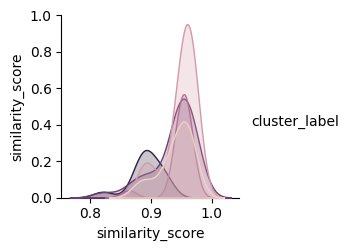

In [22]:

# Pair plot to visualize relationships

sns.pairplot(df, hue='cluster_label', diag_kind='kde')
plt.show()
